In [1]:
# 11/12-11/14
# 12/7-12/14
# 1/22-1/29
# 2/16-2/23
# 3/12-3/13
# 3/19-3/20
# 3/31-4/3
# 4/9-4/12
# 5/6-5/9
# 5/27-5/30

In [2]:
import os
import sys
sys.path.append('..')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='white', color_codes=True)

from scripts import dtaselect_QC as qc

%matplotlib inline

In [3]:
def make_date_range(date1, date2):
    return pd.date_range(date1, date2).tolist()

In [4]:
dates = [('2015-11-12', '2015-11-14'), ('2015-12-07', '2015-12-14'), 
         ('2016-01-22', '2016-01-29'), ('2016-02-16', '2016-02-23'), 
         ('2016-03-12', '2016-03-13'), ('2016-03-19', '2016-03-20'), 
         ('2016-03-31', '2016-04-03'), ('2016-04-09', '2016-04-12'), 
         ('2016-05-06', '2016-05-09'), ('2016-05-27', '2016-05-30')]

date_list = []

for date in dates:
    date_list += make_date_range(*date)

In [5]:
dates = pd.Series(date_list)

In [6]:
dates = pd.DataFrame(dates, columns = ['date'])

In [7]:
df = pd.read_csv('../data/run_info.csv', parse_dates=['date'] )

In [8]:
df.head()

,run,date,scans,protein,peptide,psm
0,20151112-UnerFecal-Lys-N15-1016/,2015-11-12,170636,131.0,516.0,2000.0
1,20151113-UnerFecal-Lys-N15-1019/,2015-11-13,185067,49.0,146.0,574.0
2,20151114-UnerFecal-Lys-N15-1021/,2015-11-14,171275,NaN,NaN,NaN
3,20151207-UnerFecal-Lys-N14N15-1021/,2015-12-07,159870,3365.0,5945.0,35274.0
4,20151208-UnerFecal-Lys-N14N15-1019/,2015-12-08,143048,1015.0,2377.0,16491.0


In [9]:
df = pd.merge(dates, df, on='date', how='left')

In [10]:
df.shape

(47, 6)

In [11]:
df = df.set_index('date')
df.head()

,run,scans,protein,peptide,psm
date,,,,,
2015-11-12,20151112-UnerFecal-Lys-N15-1016/,170636.0,131.0,516.0,2000.0
2015-11-13,20151113-UnerFecal-Lys-N15-1019/,185067.0,49.0,146.0,574.0
2015-11-14,20151114-UnerFecal-Lys-N15-1021/,171275.0,NaN,NaN,NaN
2015-12-07,20151207-UnerFecal-Lys-N14N15-1021/,159870.0,3365.0,5945.0,35274.0
2015-12-08,20151208-UnerFecal-Lys-N14N15-1019/,143048.0,1015.0,2377.0,16491.0


In [12]:
# % of days actually got to run a sample
df['run'].count() / len(df) * 100

89.361702127659569

## Looking at the Number of runs that actully produced decent data

First we'll look at how many scans there were per run.  MS2 scans per run is a decent early indicator for the possibility for good data.  Bad runs will have low counts for a varrying number of reasons.  A "Good Run" is one where data is collected the whole time.  No droplets form, there are no clogs in the tip, and no leaks that reduce the quality of the run.  

Good runs tend to have ms2 scans within 10% of one another.

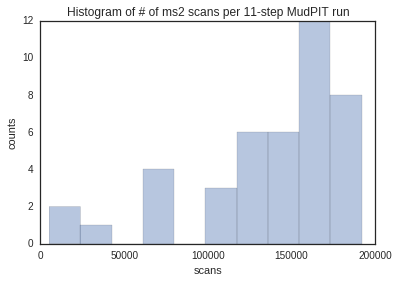

In [13]:
sns.distplot(df['scans'].dropna(), kde=False, bins=10)
plt.ylabel('counts')
plt.title('Histogram of # of ms2 scans per 11-step MudPIT run');

#### Note: changed from using an 'on-line' transfer to 'on-bomb' transfer method for samples on 2-16-2016

Should analyze these separately, as the on-bomb transfers are likely to have more scans than on-line

In [14]:
change_date = '2016-02-16'

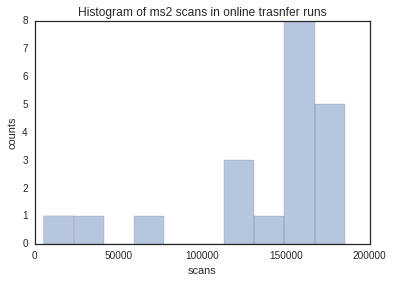

In [15]:
sns.distplot(df.loc[:change_date]['scans'].dropna(), kde=False, bins=10)
plt.ylabel('counts')
plt.title('Histogram of ms2 scans in online trasnfer runs');

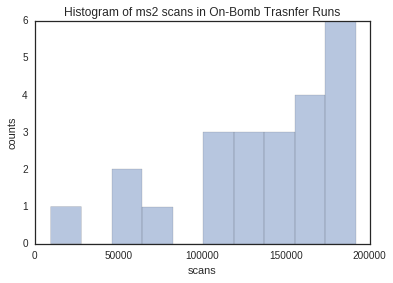

In [16]:
sns.distplot(df[change_date:]['scans'].dropna(), kde=False, bins=10)
plt.ylabel('counts')
plt.title('Histogram of ms2 scans in On-Bomb Trasnfer Runs');

Definitely seems like there's a higher upper limit for scans in runs that were transferred on bombs as opposed to inline (as there should be, since they effectively get 1 more LC step to produce data)

Now let's see if we can define a lower bound for a 'good run' and see how many of the runs fall into this category

In [17]:
good_scans_transfer = np.mean(sorted(df.loc[:change_date]['scans'], reverse=True)[:5])
good_scans_transfer

173750.79999999999

About 170,000 or so scans in a normal run with inline transfer (no peps in step 1)

In [18]:
good_scans_bomb = np.mean(sorted(df.loc[change_date:]['scans'].dropna(), reverse=True)[:5])
good_scans_bomb

188874.60000000001

Around 190,000 scans in a good run with on bomb transfer (peps in all steps)

Define a good run as > 90% of the avergae of the top 5 runs for each type (a fairly conservative estimate)

In [19]:
min_scans_transfer = good_scans_transfer * .90
min_scans_bomb = good_scans_bomb * .90

df.loc[:change_date, 'good_run'] = df.loc[:change_date, 'scans'] > min_scans_transfer
df.loc[change_date:, 'good_run'] = df.loc[change_date:, 'scans'] > min_scans_bomb

# Lets see what percentage of runs were 'good'
df['good_run'].sum() / df['run'].count() * 100

33.333333333333329

So about 1 in 3 runs actually make it all the way with good data on the machine the whole time

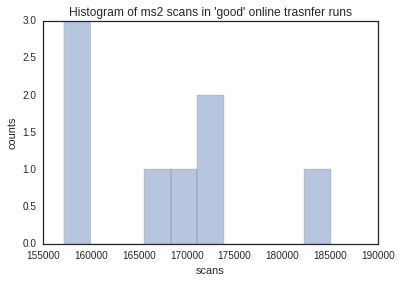

In [20]:
sns.distplot(df.query('good_run == True').loc[:change_date, 'scans'], kde=False, bins=10)
plt.ylabel('counts')
plt.title("Histogram of ms2 scans in 'good' online trasnfer runs");

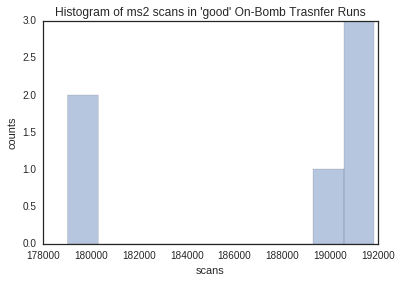

In [21]:
sns.distplot(df.query('good_run == True').loc[change_date:, 'scans'], kde=False, bins=10)
plt.ylabel('counts')
plt.title("Histogram of ms2 scans in 'good' On-Bomb Trasnfer Runs");

## Now to look at the runs a little closer and see if there's any trend in where they go wrong

In [22]:
def get_psm_per_scan(sample):
    head = '../data'
    tail = 'rawXtractor/dta-pfp-0.01/DTASelect-filter.txt'
    dta_path = os.path.join(head, sample, tail)
    name, parser = qc.get_name_parser(dta_path)
    steps, scans = qc.num_PSM_per_scan(parser)
    steps = ('step_{}'.format(s) for s in steps)
    return pd.DataFrame([scans], columns=list(steps))

In [23]:
scan_info = df.dropna()['run'].apply(get_psm_per_scan)

In [24]:
scan_info = (pd.concat(scan_info.values, keys=scan_info.keys())
               .reset_index()
               .drop('level_1', axis=1)
               .rename(columns={'level_0': 'date'})
               .set_index('date'))
scan_info.head()

,step_1,step_10,step_11,step_2,step_3,step_4,step_5,step_6,step_7,step_8,step_9
date,,,,,,,,,,,
2015-11-12,NaN,23.0,24.0,64.0,76.0,60,44.0,55.0,53.0,39.0,55.0
2015-11-13,NaN,5.0,9.0,13.0,21.0,20,14.0,14.0,12.0,11.0,18.0
2015-12-07,1.0,175.0,471.0,1157.0,896.0,687,624.0,478.0,450.0,430.0,454.0
2015-12-08,NaN,38.0,107.0,595.0,394.0,285,215.0,208.0,175.0,146.0,156.0
2015-12-09,1.0,321.0,270.0,1118.0,784.0,575,567.0,465.0,397.0,370.0,580.0


In [25]:
df1 = pd.concat([df, scan_info], axis=1)
df1.head()

,run,scans,protein,peptide,psm,good_run,step_1,step_10,step_11,step_2,step_3,step_4,step_5,step_6,step_7,step_8,step_9
date,,,,,,,,,,,,,,,,,
2015-11-12,20151112-UnerFecal-Lys-N15-1016/,170636.0,131.0,516.0,2000.0,True,NaN,23.0,24.0,64.0,76.0,60.0,44.0,55.0,53.0,39.0,55.0
2015-11-13,20151113-UnerFecal-Lys-N15-1019/,185067.0,49.0,146.0,574.0,True,NaN,5.0,9.0,13.0,21.0,20.0,14.0,14.0,12.0,11.0,18.0
2015-11-14,20151114-UnerFecal-Lys-N15-1021/,171275.0,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-12-07,20151207-UnerFecal-Lys-N14N15-1021/,159870.0,3365.0,5945.0,35274.0,True,1.0,175.0,471.0,1157.0,896.0,687.0,624.0,478.0,450.0,430.0,454.0
2015-12-08,20151208-UnerFecal-Lys-N14N15-1019/,143048.0,1015.0,2377.0,16491.0,False,NaN,38.0,107.0,595.0,394.0,285.0,215.0,208.0,175.0,146.0,156.0


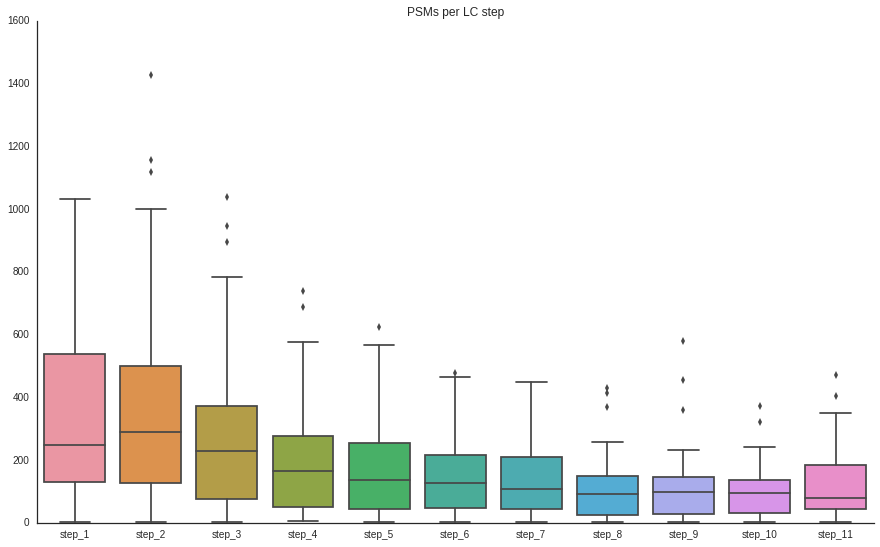

In [26]:
steps = ['step_{}'.format(x+1) for x in range(11)]
fig = plt.figure(figsize=(15,9))
sns.boxplot(data=df1[steps])
plt.title('PSMs per LC step')
sns.despine();

Nothing too revealing here.... lets just count how many steps have nothing at all

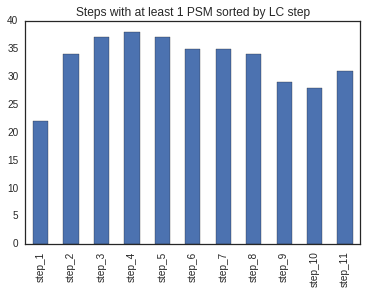

In [27]:
# get rid of one's that didn't run as to not artifically inflate missing scans
df1.dropna(subset=['psm'])[steps].count().plot(kind='bar')
plt.title('Steps with at least 1 PSM sorted by LC step');

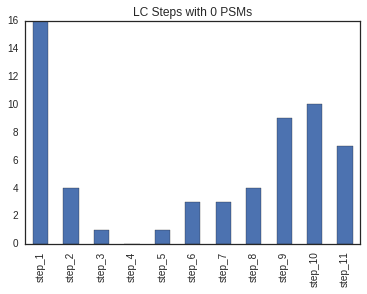

In [28]:
(df1['psm'].count() - df1.dropna(subset=['psm'])[steps].count()).plot(kind='bar');
plt.title('LC Steps with 0 PSMs');

Definitely more issues in the later salt steps.  The number for the first step is inflated becasue of the inline transfer samples.  Lets subtract those out.

Furhther, having only 1 PSM does not make it a good LC step, let's set a minimum of 10 and look how many fail that threshold.

In [29]:
inline_samps = len(df1.loc[:change_date].dropna(subset=['psm']))

# Start with good steps because any int comparison with np.nan returns False
good_steps = df1.dropna(subset=['psm'])[steps] > 10 
good_steps.head()

,step_1,step_2,step_3,step_4,step_5,step_6,step_7,step_8,step_9,step_10,step_11
date,,,,,,,,,,,
2015-11-12,False,True,True,True,True,True,True,True,True,True,True
2015-11-13,False,True,True,True,True,True,True,True,True,False,False
2015-12-07,False,True,True,True,True,True,True,True,True,True,True
2015-12-08,False,True,True,True,True,True,True,True,True,True,True
2015-12-09,False,True,True,True,True,True,True,True,True,True,True


In [30]:
poor_steps = ~good_steps
poor_steps.head()

,step_1,step_2,step_3,step_4,step_5,step_6,step_7,step_8,step_9,step_10,step_11
date,,,,,,,,,,,
2015-11-12,True,False,False,False,False,False,False,False,False,False,False
2015-11-13,True,False,False,False,False,False,False,False,False,True,True
2015-12-07,True,False,False,False,False,False,False,False,False,False,False
2015-12-08,True,False,False,False,False,False,False,False,False,False,False
2015-12-09,True,False,False,False,False,False,False,False,False,False,False


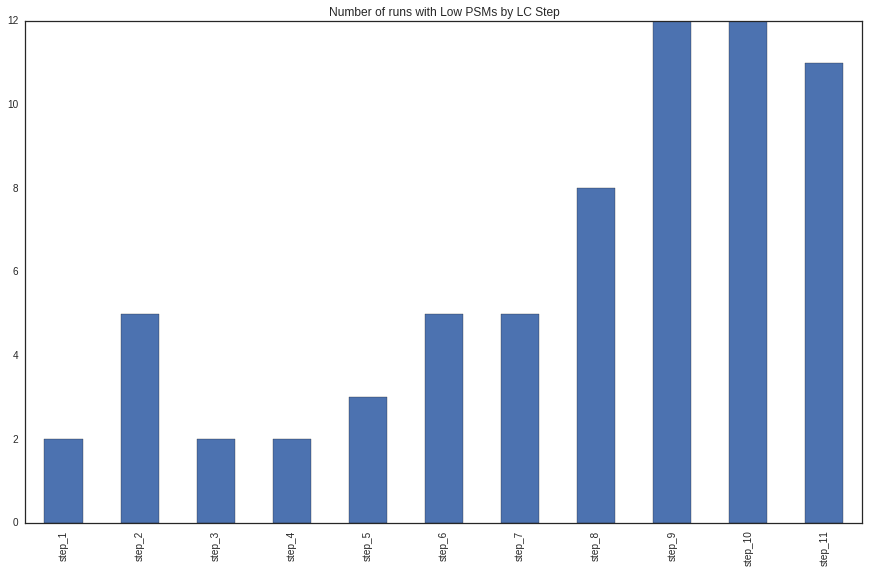

In [31]:
summed = poor_steps[steps].sum()
summed['step_1'] = summed['step_1'] - inline_samps

plt.figure(figsize=(15,9))
summed.plot(kind='bar');
plt.title('Number of runs with Low PSMs by LC Step');

Definitely the later steps that seem to produce the most problems

In [32]:
before_change = df1.dropna(subset=['psm']).loc[:change_date]
after_change = df1.dropna(subset=['psm']).loc[change_date:]

First we'll look at after making the change to on-bomb loading.  We'll start by ones that that had less than 11 good LC Steps.  These should all be classified as False by under the characteristic 'good_run'

In [33]:
after_change[good_steps.loc[change_date:].sum(axis=1) < 11]['good_run']

date
2016-02-16    False
2016-02-22    False
2016-02-23    False
2016-03-12    False
2016-03-19    False
2016-03-20    False
2016-04-02    False
2016-04-03    False
2016-04-10    False
2016-04-11    False
2016-04-12    False
2016-05-06    False
2016-05-07    False
2016-05-08    False
2016-05-28    False
Name: good_run, dtype: bool

All are in agreement, so no need to look at anything here

Next look at the ones that had 11 good LC steps, and see if the run was good.

In [34]:
dat = after_change[good_steps.loc[change_date:].sum(axis=1) > 10]
idxs = after_change[good_steps.loc[change_date:].sum(axis=1) > 10]['good_run']
idxs

date
2016-02-18     True
2016-02-19     True
2016-02-20     True
2016-03-31     True
2016-04-09     True
2016-05-09     True
2016-05-29    False
Name: good_run, dtype: bool

Let's take a look at which one didn't pass the test and find out why

In [35]:
dat[~idxs]

,run,scans,protein,peptide,psm,good_run,step_1,step_10,step_11,step_2,step_3,step_4,step_5,step_6,step_7,step_8,step_9
date,,,,,,,,,,,,,,,,,
2016-05-29,20160529-DMSO-Lys-N14N15-Pool/,169222.0,165.0,579.0,3551.0,False,120.0,17.0,53.0,106.0,59.0,64.0,30.0,40.0,24.0,23.0,27.0


This run had a really wonky calibration issues, therefore needed some heavy editing even to get good data.  It's not surprising that although there were psm's througout, the scan number was short of the threshold for a good run.

Now do the same for the samples before chaning to on-bomb transfers.  These will only have a max of 10 good LC steps.

In [36]:
dat = before_change[good_steps.loc[:change_date].sum(axis=1) < 10] 
idxs = before_change[good_steps.loc[:change_date].sum(axis=1) < 10]['good_run']
idxs

date
2015-11-13     True
2015-12-13    False
2015-12-14    False
2016-01-26    False
2016-02-16    False
Name: good_run, dtype: bool

In [37]:
dat[idxs]

,run,scans,protein,peptide,psm,good_run,step_1,step_10,step_11,step_2,step_3,step_4,step_5,step_6,step_7,step_8,step_9
date,,,,,,,,,,,,,,,,,
2015-11-13,20151113-UnerFecal-Lys-N15-1019/,185067.0,49.0,146.0,574.0,True,NaN,5.0,9.0,13.0,21.0,20.0,14.0,14.0,12.0,11.0,18.0


This one was an N15 only sample from early in the series, before all the n15 enrichment was above 90%.  This makes sense as to why there are such low PSMs when the scans are so high.

Moving on to the next set.

In [38]:
dat = before_change[good_steps.loc[:change_date].sum(axis=1) > 9] 
idxs = before_change[good_steps.loc[:change_date].sum(axis=1) > 9]['good_run']
idxs

date
2015-11-12     True
2015-12-07     True
2015-12-08    False
2015-12-09    False
2015-12-10     True
2015-12-11     True
2015-12-12    False
2016-01-22     True
2016-01-24    False
2016-01-25    False
2016-01-27    False
2016-01-29     True
Name: good_run, dtype: bool

A lot of disagreement here... they should all be true at this point.  Lets take a closer look at the ones that returned False and see if there's anything that can explain this.

In [39]:
dat[~idxs]

,run,scans,protein,peptide,psm,good_run,step_1,step_10,step_11,step_2,step_3,step_4,step_5,step_6,step_7,step_8,step_9
date,,,,,,,,,,,,,,,,,
2015-12-08,20151208-UnerFecal-Lys-N14N15-1019/,143048.0,1015.0,2377.0,16491.0,False,NaN,38.0,107.0,595.0,394.0,285.0,215.0,208.0,175.0,146.0,156.0
2015-12-09,20151209-UnerFecal-Lys-N14N15-1016/,155717.0,3322.0,5507.0,32419.0,False,1.0,321.0,270.0,1118.0,784.0,575.0,567.0,465.0,397.0,370.0,580.0
2015-12-12,20151212-UnerFecal-Sup-N14N15-1016/,149768.0,325.0,1648.0,18465.0,False,NaN,132.0,145.0,296.0,229.0,170.0,112.0,126.0,108.0,123.0,136.0
2016-01-24,20160124-AOMKFecal-Lys-N14N15-1120/,152915.0,264.0,944.0,9241.0,False,NaN,81.0,78.0,200.0,144.0,83.0,69.0,65.0,68.0,56.0,71.0
2016-01-25,20160125-CMKFecal-Lys-N14N15-1120/,150462.0,1069.0,2578.0,18097.0,False,NaN,99.0,76.0,512.0,352.0,241.0,256.0,295.0,228.0,218.0,232.0
2016-01-27,20160127-UnerFecal-Lys-N14N15-1121/,113936.0,441.0,1396.0,13090.0,False,NaN,31.0,37.0,188.0,340.0,279.0,45.0,93.0,104.0,118.0,68.0


There's really nothing to explain this... All with the exception of the run on 2016-01-27 (and maybe 2015-12-08) look like they could be good runs.  I may need to relax the parameters for a 'good run' on samples with on-line transfer to around > 149,500 or so.

In [40]:
min_scans_transfer = good_scans_transfer * .85

df1.loc[:change_date, 'good_run'] = df1.loc[:change_date, 'scans'] > min_scans_transfer

In [41]:
before_change = df1.dropna(subset=['psm']).loc[:change_date]
after_change = df1.dropna(subset=['psm']).loc[change_date:]

dat = before_change[good_steps.loc[:change_date].sum(axis=1) < 10] 
idxs = before_change[good_steps.loc[:change_date].sum(axis=1) < 10]['good_run']
idxs

date
2015-11-13     True
2015-12-13    False
2015-12-14    False
2016-01-26    False
2016-02-16     True
Name: good_run, dtype: bool

In [42]:
dat[idxs]

,run,scans,protein,peptide,psm,good_run,step_1,step_10,step_11,step_2,step_3,step_4,step_5,step_6,step_7,step_8,step_9
date,,,,,,,,,,,,,,,,,
2015-11-13,20151113-UnerFecal-Lys-N15-1019/,185067.0,49.0,146.0,574.0,True,NaN,5.0,9.0,13.0,21.0,20.0,14.0,14.0,12.0,11.0,18.0
2016-02-16,20160216-UnerFecal-Lys-N14N15-1111/,163682.0,412.0,1643.0,16940.0,True,NaN,149.0,53.0,NaN,372.0,271.0,216.0,139.0,147.0,104.0,127.0


In [43]:
dat = before_change[good_steps.loc[:change_date].sum(axis=1) > 9] 
idxs = before_change[good_steps.loc[:change_date].sum(axis=1) > 9]['good_run']
idxs

date
2015-11-12     True
2015-12-07     True
2015-12-08    False
2015-12-09     True
2015-12-10     True
2015-12-11     True
2015-12-12     True
2016-01-22     True
2016-01-24     True
2016-01-25     True
2016-01-27    False
2016-01-29     True
Name: good_run, dtype: bool

In [44]:
dat[~idxs]

,run,scans,protein,peptide,psm,good_run,step_1,step_10,step_11,step_2,step_3,step_4,step_5,step_6,step_7,step_8,step_9
date,,,,,,,,,,,,,,,,,
2015-12-08,20151208-UnerFecal-Lys-N14N15-1019/,143048.0,1015.0,2377.0,16491.0,False,NaN,38.0,107.0,595.0,394.0,285.0,215.0,208.0,175.0,146.0,156.0
2016-01-27,20160127-UnerFecal-Lys-N14N15-1121/,113936.0,441.0,1396.0,13090.0,False,NaN,31.0,37.0,188.0,340.0,279.0,45.0,93.0,104.0,118.0,68.0


It's looking better now.  I appear to be dropping one good one as bad (2015-12-08) and one clearly bad one (2016-02-16 has no PSMs in step 2) has snuck in, classified as good.  However, these seem to balance out.

In [45]:
# How does this change the percentage of "good runs?"
df1['good_run'].sum() / df1['run'].count() * 100

45.238095238095241

In [46]:
no_runs = 100 - (df1['run'].count() / len(df1)) * 100

good_runs = df1['good_run'].sum() / len(df1) * 100

bad_runs = (~df1.dropna(subset=['run'])['good_run']).sum() / len(df1) * 100 

good_runs + bad_runs + no_runs

100.0

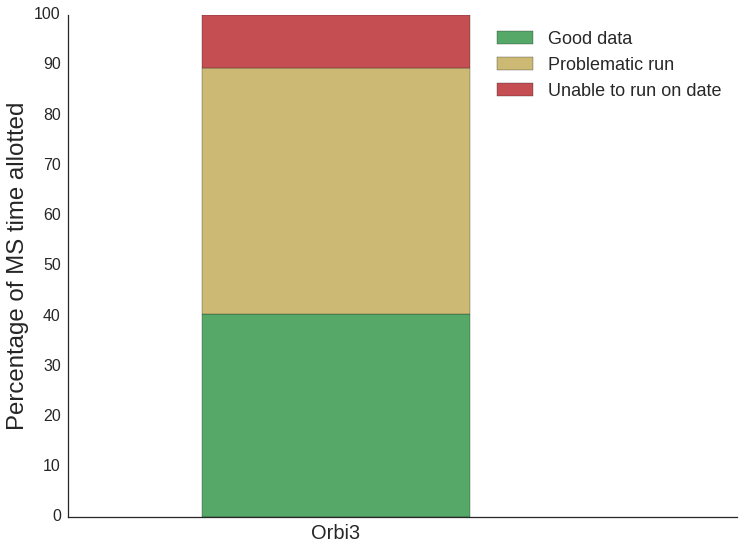

In [47]:
fig = plt.figure(figsize=(12, 9))

p1 = plt.bar(1,good_runs, .5, color = 'g')
p2 = plt.bar(1,bad_runs, .5, bottom=good_runs, color='y')
p3 = plt.bar(1,no_runs, .5, bottom=good_runs+bad_runs, color='r')

plt.xticks([1.25], ['Orbi3', ''], size = 20)
plt.xlim(.75, 2)
plt.ylabel('Percentage of MS time allotted', size=24)
plt.yticks(np.arange(0, 101, 10), size=16)
plt.ylim(0,100)
plt.legend((p1[0], p2[0], p3[0]), ('Good data', 'Problematic run', 'Unable to run on date'), prop={'size':18})

sns.despine()

In [48]:
print('Days allotted on Orbi3 since last November: ', len(df1))
print('Days that produced runs with good data: ', df1['good_run'].sum())
print('Runs that had problems with at least 1 LC Step: ', (~df1.dropna(subset=['run'])['good_run']).sum())
print('Days when no run could be performed: ', len(df1) - df1['run'].count()) 

Days allotted on Orbi3 since last November:  47
Days that produced runs with good data:  19
Runs that had problems with at least 1 LC Step:  23
Days when no run could be performed:  5
